In [29]:
# Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [30]:
# Step 1: Load Data (Las Vegas)
df = pd.read_csv("Resources/lasvegaslistings.csv")

In [31]:
# Step 2: Data Cleaning (simplified example)
selected_columns = [
    "price", "latitude", "longitude", "room_type", "minimum_nights",
    "number_of_reviews", "reviews_per_month",
    "calculated_host_listings_count", "availability_365", "neighbourhood"
]
df_model = df[selected_columns].dropna()
df_model = df_model[df_model["price"] > 0]

In [32]:
# Convert price from string to float if needed
price_cap = df_model["price"].quantile(0.95)
df_model = df_model[df_model["price"] <= price_cap]

In [33]:
# Step 3: Feature Engineering
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_model["location_cluster"] = kmeans.fit_predict(df_model[["latitude", "longitude"]])


In [34]:
# Step 4: Train/Test Split
df_model["log_reviews"] = np.log1p(df_model["number_of_reviews"])
df_model["log_reviews_per_month"] = np.log1p(df_model["reviews_per_month"])

In [35]:
# Step 5: Model 1 - Random Forest Regressor (default parameters)
df_model["minnights_x_reviews"] = df_model["minimum_nights"] * df_model["reviews_per_month"]
df_model["lat_squared"] = df_model["latitude"] ** 2
df_model["long_squared"] = df_model["longitude"] ** 2

In [36]:
# Step 6: Model 2 - Linear Regression (baseline model)
df_model["price_class"] = pd.qcut(df_model["price"], q=2, labels=[0, 1])


In [37]:
# Step 7: Evaluation
X = df_model[[
    "latitude", "longitude", "lat_squared", "long_squared", "log_reviews", "log_reviews_per_month",
    "minimum_nights", "minnights_x_reviews", "calculated_host_listings_count", "availability_365",
    "room_type", "location_cluster", "neighbourhood"
]]
y = df_model["price_class"].astype(int)

In [38]:
numeric_features = [
    "latitude", "longitude", "lat_squared", "long_squared",
    "log_reviews", "log_reviews_per_month", "minimum_nights",
    "minnights_x_reviews", "calculated_host_listings_count", "availability_365"
]
categorical_features = ["room_type", "location_cluster", "neighbourhood"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown='ignore'), categorical_features),
    ]
)

In [39]:
# Step 8: Visualizations
results = []
param_grid = [
    {"n_estimators": 300, "max_depth": None},
    {"n_estimators": 400, "max_depth": 30},
    {"n_estimators": 500, "max_depth": 40},
    {"n_estimators": 600, "max_depth": 50},
]

for params in param_grid:
    model = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(
            random_state=42,
            n_estimators=params["n_estimators"],
            max_depth=params["max_depth"]
        ))
    ])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results.append({"n_estimators": params["n_estimators"], "max_depth": params["max_depth"], "accuracy": acc})

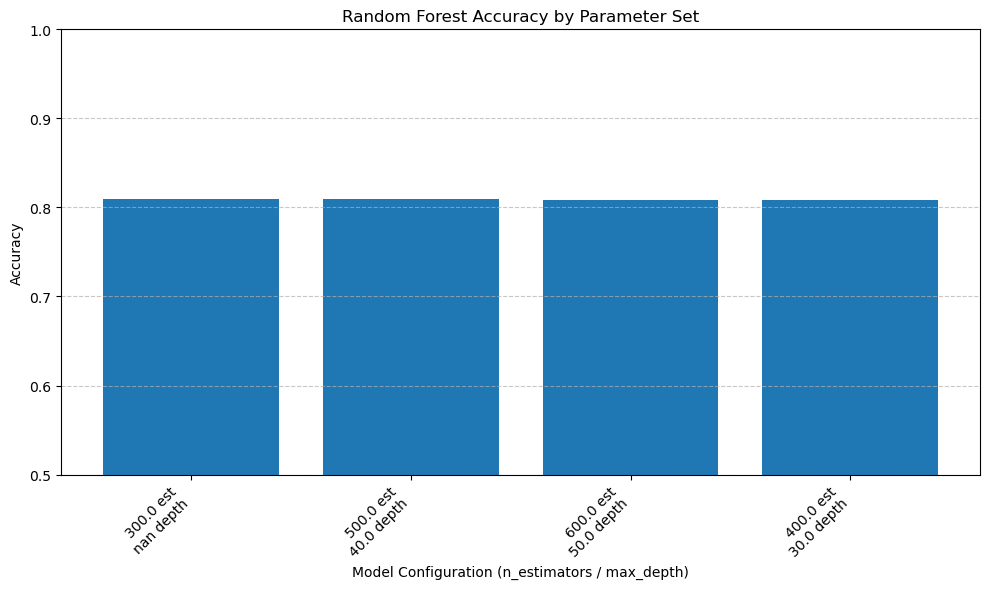


Best Model Parameters:
n_estimators    300.000000
max_depth              NaN
accuracy          0.809935
Name: 0, dtype: float64


In [40]:
# Save performance results and visualize accuracy
results_df = pd.DataFrame(results)
results_df.to_csv("classification_optimization_results.csv", index=False)

# 📊 Accuracy Plot
import matplotlib.pyplot as plt

results_df_sorted = results_df.sort_values(by="accuracy", ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(
    [f"{row['n_estimators']} est\n{row['max_depth']} depth" for _, row in results_df_sorted.iterrows()],
    results_df_sorted["accuracy"]
)

plt.title("Random Forest Accuracy by Parameter Set")
plt.xlabel("Model Configuration (n_estimators / max_depth)")
plt.ylabel("Accuracy")
plt.xticks(rotation=45, ha="right")
plt.ylim(0.5, 1.0)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 🏆 Print Best Model Parameters
best_result = results_df_sorted.iloc[0]
print("\nBest Model Parameters:")
print(best_result)



In [41]:
# Save predictions to CSV
best_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        random_state=42,
        n_estimators=int(best_result["n_estimators"]),
        max_depth=None if pd.isna(best_result["max_depth"]) else int(best_result["max_depth"])
    ))
])
best_model.fit(X_train, y_train)
y_pred_rf = best_model.predict(X_test)

# Save predictions
predictions = pd.DataFrame({
    "Actual": y_test,
    "RF_Predicted": y_pred_rf
})
predictions.to_csv("las_vegas_price_model_comparison.csv", index=False)

In [42]:
# Extract feature importances from the best Random Forest model
importances = best_model.named_steps["classifier"].feature_importances_

In [43]:
# Get feature names from the preprocessor
feature_names = best_model.named_steps["preprocessor"].get_feature_names_out()

In [44]:
# Combine into a DataFrame
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

In [45]:
# Display top 10 most important features
print("Top 10 Most Important Features for Predicting High Price Listings:")
print(importance_df.head(10))

Top 10 Most Important Features for Predicting High Price Listings:
                                Feature  Importance
3                     num__long_squared    0.102380
1                        num__longitude    0.098283
7              num__minnights_x_reviews    0.096771
2                      num__lat_squared    0.094202
0                         num__latitude    0.094001
11          cat__room_type_Private room    0.090504
5            num__log_reviews_per_month    0.086337
9                 num__availability_365    0.082667
6                   num__minimum_nights    0.080933
8   num__calculated_host_listings_count    0.071715


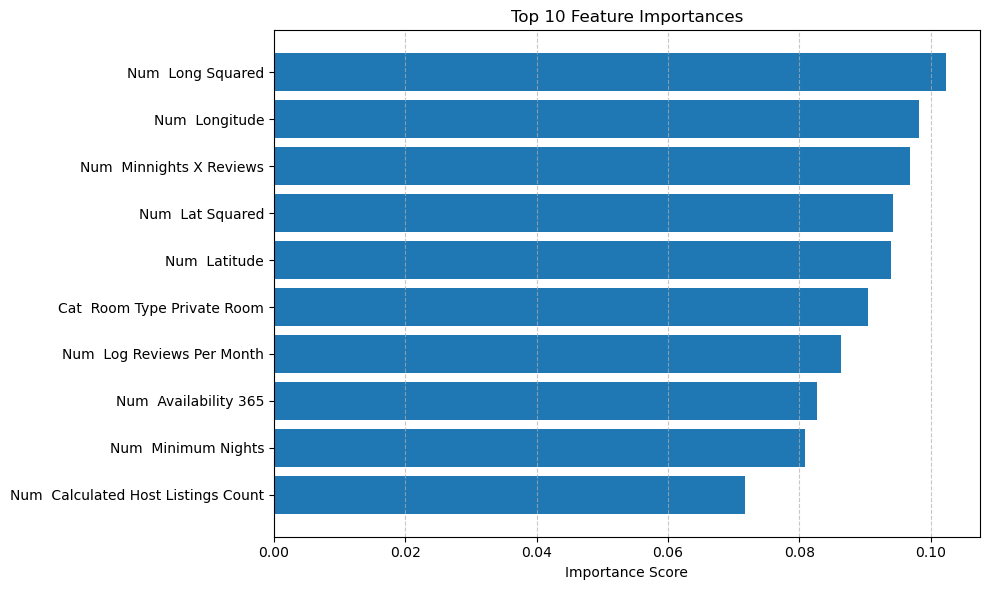

In [46]:
# Plotting the feature importances

import matplotlib.pyplot as plt

# Format feature names for readability
importance_df["Formatted Feature"] = importance_df["Feature"].str.replace("_", " ").str.title()

# Plot with updated Y-axis labels
plt.figure(figsize=(10, 6))
plt.barh(importance_df.head(10)["Formatted Feature"], importance_df.head(10)["Importance"])
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()